In [1]:
data_type = 'red_data' # reduced data

In [2]:
import sys
sys.path.insert(0, '../..')
from definition import (
    data_names,
    limits_m_Kpipi,
    columns
)

MC_name   = data_names['MC']
data_name = data_names[data_type]
weight_MC_name = data_names['weight_MC']

low_m_Kpipi = limits_m_Kpipi[data_type]['low']
high_m_Kpipi = limits_m_Kpipi[data_type]['high']

print("MC name: ", MC_name)
print("data name: ", data_name)
print("weight MC name: ", weight_MC_name)
print('----')
print('m_Kpipi')
print("low: ", low_m_Kpipi)
print("high: ", high_m_Kpipi)

MC name:  BTODstDX_MC
data name:  BTODstDX_reduced
weight MC name:  BTODstDX_MC_weights
----
m_Kpipi
low:  1820
high:  1950


The columns that need to be looked at are:
- $q^2$: `q2_reco`
- *isolation BDT*: `isolation_bdt`
- $t_\tau$: `tau_life_reco`
- $m(D^*K\pi\pi)$: `m_DstKpipi`
- The angles 
    - $\theta_X$ ($=\theta_D$ of the paper?): `theta_X_reco`
    - $\theta_L$: `theta_L_reco`
    - $\chi$: `chi_reco`

# Reweighting MC sample of $B \to D^{*-}\left(D^{+} \to K^- \pi^+ \pi^+  \right)X$ Background

**INPUTS**
- `MC`: $D^+ \to K^- \pi^+ \pi^-$
- `data`: LHCb data, with $_s$Weights to project in the $D^+ \to K^- \pi^+ \pi^-$ contribution and project out the other contributions.

**GOALS**
1. to learn the weights to apply to MC to align MC to data for the $D^+ \to K^- \pi^+ \pi^- $ decays by looking at the MC and $_s$Weighted LHCb data (using BDTs),
2. to apply the weights to the general MC.

We hope that this will reweight the general MC sample for $B \to D^{*-} (D^+ \to 3\pi X) X$

In [3]:
# python libraries
import numpy as np
import pandas as pd
import zfit
import timeit
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from itertools import product

# hep_ml
from hep_ml.reweight import GBReweighter

# bd2dsttaunu
from bd2dsttaunu.locations import loc

# HEA library
from HEA.plot import plot_hist_auto, plot_hist, save_fig, plot_hist_var
from HEA import load_dataframe
from HEA.plot.tools import draw_vline
from HEA.definition import latex_params
from HEA.pandas_root import load_saved_root
from HEA.pandas_root import save_root
import HEA.BDT as bt
from HEA.tools.serial import dump_joblib, retrieve_joblib

Welcome to JupyROOT 6.22/06


## Read the dataframe

In [8]:
df = {}
df['MC'] = load_dataframe(loc.B2DstDplusX_MC, tree_name='DecayTreeTuple/DecayTree', columns=columns+['m_Kpipi'])
df['data'] = load_saved_root(data_name + '_with_sWeights', folder_name=data_name)

Loading /data/lhcb/users/scantlebury-smead/angular_analysis/double_charm/final_ds_selection_B_DstDpX_Kpipi_truth_matched.root
Loading /home/correiaa/bd2dsttaunu/output//root/BTODstDX_reduced/BTODstDX_reduced_with_sWeights.root


In [9]:
df['MC'] = df['MC'].query(f'm_Kpipi > {low_m_Kpipi} and m_Kpipi < {high_m_Kpipi}')
# df['data'] = df['data'].query(f'm_Kpipi > {low_m_Kpipi} and m_Kpipi < {high_m_Kpipi}')

In [10]:
len_MC = len(df['MC'])
print(len_MC)

8224


In [11]:
df['data'] = df['data'].dropna()
df['MC'] = df['MC'].dropna()

df['data'].reset_index(drop=True, inplace=True)
df['MC'].reset_index(drop=True, inplace=True)

In [12]:
print(( len_MC - len(df['MC']) ) / len_MC)

0.004620622568093385


## Theory - reweighting the MC data
https://indico.cern.ch/event/397113/contributions/1837841/attachments/1213955/1771752/ACAT2016-reweighting.pdf

Use of the `hep_ml` package: documentation [here](https://arogozhnikov.github.io/hep_ml/reweight.html)

### Explanation
#### 1D comparison cannot be used
We could assign compute the weights in the following way:\
For the bin $i$: 
$$w_{i}= \frac{\text{#data}[i]}{\text{#MC}[i]}$$

Disadvantages:
- Reweighting one variable might bring disagreement to others\
$\Rightarrow$ we need a multi-dimensional reweighting procedure.\
$\Rightarrow$ we need to compare multi-dimensional histograms!
- We need to choose the number of bins

#### Use ML (boosted reweighting)
The procedure is automatised using a ML classifier using decision trees (e.g., gradient classifier).\
1. Dataset = concatenated MC and data (goal: classify MC and data events via a ML classifier)
2. Tree splits the space of variables orthogonaly to maximise the difference between MC and LHCb data in these regions. The difference is evaluated with the symmetrised $\chi^2$ (instead of the usual *MSE*):
$$\chi^2 = \sum_{\text{bin }i} \frac{\left(\text{#data}[i]-\text{#MC}[i]\right)^2}{\text{#data}[i]+\text{#MC}[i]}$$
2. Compute weight predictions in leaves

Advantages:
- Optimal choice of region
- Information about the efficiency of the procedure (via the ROC curve for instance)
- The ML classifier can be used to re-weight other MC samples
- Posssible computation of feature importances

Disadvantage: slow



### `GBReweighter` in `hep_ml`

We are going to use a `GBReweighter` from the `hep_ml` package. Hopefully, a description is provided by the documentation:

*Gradient Boosted Reweighter - a reweighter algorithm based on ensemble of regression trees. Parameters have the same role, as in gradient boosting. Special loss function is used, trees are trained to maximize symmetrized binned chi-squared statistics.*

*Training takes much more time than for bin-based versions, but GBReweighter is capable to work in high dimensions while keeping reweighting rule reliable and precise (and even smooth if many trees are used).*

## Prepare the dataframes

### Pick up the variables

In [13]:
print(f"{len(columns)} available columns:")
for column in columns:
    print("- " + column)

13 available columns:
- m_Kpipi
- q2_reco
- isolation_bdt
- tau_life_reco
- m_DstKpipi
- theta_X_reco
- theta_L_reco
- chi_reco
- costheta_X_reco
- costheta_L_reco
- coschi_reco
- tau_M
- B0_M


In [14]:
training_columns = [
    'costheta_X_reco',
    'costheta_L_reco',
    'chi_reco',
    'isolation_bdt',
    'q2_reco',
    'B0_M'
]

print(f"{len(training_columns)} columns used for training of the GBRWeighter:")
for training_column in training_columns:
    print("- " + training_column)

6 columns used for training of the GBRWeighter:
- costheta_X_reco
- costheta_L_reco
- chi_reco
- isolation_bdt
- q2_reco
- B0_M


We'll add the $_s$Weights to this list

### Split the dataframes in two

In [15]:
two_dfs = {
    1 : {},
    2 : {}
}

In [16]:
for type_df in df.keys():
    print(type_df)
    two_dfs[1][type_df] = df[type_df].sample(frac=0.5, random_state=20)
    two_dfs[2][type_df] = df[type_df].drop(two_dfs[1][type_df].sort_index().index,0).sample(frac=1., random_state=20)

MC
data


Check: print the number of element in each df.

In [17]:
for type_df in df.keys():
    print(len(two_dfs[1][type_df]), len(two_dfs[2][type_df]))

4093 4093
48010 48010


### Get the dataframes with only the training variables + the $_s$Weights

In [18]:
reweight_two_dfs = {
    1 : {},
    2 : {}
}
for num in reweight_two_dfs.keys():
    reweight_two_dfs[num]['MC'] = two_dfs[num]['MC'][training_columns]
    reweight_two_dfs[num]['data'] = two_dfs[num]['data'][training_columns + ['sWeight']]

Check if it worked...

In [19]:
for num in two_dfs.keys():
    for type_df in two_dfs[num].keys():
        assert (reweight_two_dfs[num]['MC'].columns == training_columns).all()
        assert (reweight_two_dfs[num]['data'].columns == training_columns + ['sWeight']).all()

### Divide into training and test samples

In [20]:
train_reweight_two_dfs = {
    1 : {},
    2 : {}
}
test_reweight_two_dfs = {
    1 : {},
    2 : {}
}

In [21]:
for num in two_dfs.keys():
    for type_df in two_dfs[num].keys():
        train_reweight_two_dfs[num][type_df], test_reweight_two_dfs[num][type_df] =\
            train_test_split(reweight_two_dfs[num][type_df], 
                             test_size=0.5,
                             random_state=20)

Check if it worked

In [22]:
for type_df in two_dfs.keys():
    for num in two_dfs[type_df].keys():
        print(len(train_reweight_two_dfs[type_df][num]), len(test_reweight_two_dfs[type_df][num]))

2046 2047
24005 24005
2046 2047
24005 24005


## Hyperparameters tuning 

In [23]:
from HEA.tools import get_chi2_2samp

In [24]:
def compute_score(train_weights, test_weights):
    return ks_2samp(train_weights, test_weights).statistic

def compute_pvalue(train_weights, test_weights):
    return ks_2samp(train_weights, test_weights).pvalue

def compute_chi2(data_test_df, MC_test_df, data_test_weight, MC_test_weight, n_bins=15):
    columns = data_test_df.columns
    chi2 = 0
    for column in columns:
        data = data_test_df[column]
        original_MC = MC_test_df[column]
                
        chi2 += get_chi2_2samp(original_MC, data, 
                               n_bins=n_bins,
                               low=None, high=None,
                               weights1=MC_test_weight, 
                               weights2=data_test_weight)
    return chi2

In [25]:
def get_best_params(param_grid,
                    original_train_df, target_train_df, 
                    original_test_df, target_test_df,
                    target_train_weight=None, 
                    target_test_weight=None,
                    **fit_params):
    best_param_values = {}

    param_values_lists = product(*param_grid.values())
    param_names = param_grid.keys()
    
    best_score = np.inf
    
    scores = {}
    p_values = {}
    
    for param_values_list in param_values_lists:
        
        hyperparams = dict(zip(param_names, param_values_list))
        print("test of ")
        print(hyperparams)
        
        reweighter = GBReweighter(gb_args={'random_state': 20},
                                  **hyperparams)
        reweighter = reweighter.fit(
            original=original_train_df,
            target=target_train_df,
            target_weight=target_train_weight,
            **fit_params
        )
        
        MC_test_weight = reweighter.predict_weights(original_test_df)
        MC_train_weight = reweighter.predict_weights(original_train_df)
        
        scores[tuple(param_values_list)] = compute_chi2(
            data_test_df=target_test_df,
            MC_test_df=original_test_df,
            data_test_weight=target_test_weight,
            MC_test_weight=MC_test_weight,
        )
        
        p_values[tuple(param_values_list)] = compute_pvalue(MC_train_weight, MC_test_weight)
        
        
        if scores[tuple(param_values_list)] < best_score:
            best_score = scores[tuple(param_values_list)]
            best_param_values = tuple(param_values_list)
        
    return scores, p_values, best_param_values  


In [26]:
param_grid = {
    "n_estimators": np.arange(10, 66, 5),
    'learning_rate': [0.08],
    "max_depth": [2]
}


In [27]:
scores = {}
best_param_values = {}
p_values = {}
for num in train_reweight_two_dfs.keys():
    scores[num], p_values[num], best_param_values[num] = get_best_params(
        param_grid,
        original_train_df=train_reweight_two_dfs[num]['MC'], 
        target_train_df=train_reweight_two_dfs[num]['data'].drop('sWeight', 1),
        original_test_df=test_reweight_two_dfs[num]['MC'],
        target_test_df=test_reweight_two_dfs[num]['data'].drop('sWeight', 1),
        target_train_weight=train_reweight_two_dfs[num]['data']['sWeight'],
        target_test_weight=test_reweight_two_dfs[num]['data']['sWeight'])

test of 
{'n_estimators': 10, 'learning_rate': 0.08, 'max_depth': 2}
test of 
{'n_estimators': 15, 'learning_rate': 0.08, 'max_depth': 2}
test of 
{'n_estimators': 20, 'learning_rate': 0.08, 'max_depth': 2}
test of 
{'n_estimators': 25, 'learning_rate': 0.08, 'max_depth': 2}
test of 
{'n_estimators': 30, 'learning_rate': 0.08, 'max_depth': 2}
test of 
{'n_estimators': 35, 'learning_rate': 0.08, 'max_depth': 2}
test of 
{'n_estimators': 40, 'learning_rate': 0.08, 'max_depth': 2}
test of 
{'n_estimators': 45, 'learning_rate': 0.08, 'max_depth': 2}
test of 
{'n_estimators': 50, 'learning_rate': 0.08, 'max_depth': 2}
test of 
{'n_estimators': 55, 'learning_rate': 0.08, 'max_depth': 2}
test of 
{'n_estimators': 60, 'learning_rate': 0.08, 'max_depth': 2}
test of 
{'n_estimators': 65, 'learning_rate': 0.08, 'max_depth': 2}
test of 
{'n_estimators': 10, 'learning_rate': 0.08, 'max_depth': 2}
test of 
{'n_estimators': 15, 'learning_rate': 0.08, 'max_depth': 2}
test of 
{'n_estimators': 20, 'lea

In [28]:
best_param_values

{1: (35, 0.08, 2), 2: (25, 0.08, 2)}

In [29]:
scores

{1: {(10, 0.08, 2): 27.774233346785845,
  (15, 0.08, 2): 26.10248888861819,
  (20, 0.08, 2): 26.035388607587937,
  (25, 0.08, 2): 25.871109179273404,
  (30, 0.08, 2): 25.43106312517091,
  (35, 0.08, 2): 25.018404600125137,
  (40, 0.08, 2): 25.49538216505264,
  (45, 0.08, 2): 25.98759454699293,
  (50, 0.08, 2): 26.47816388943056,
  (55, 0.08, 2): 26.635096133626906,
  (60, 0.08, 2): 27.827105971950054,
  (65, 0.08, 2): 30.13681848366454},
 2: {(10, 0.08, 2): 21.47729643496763,
  (15, 0.08, 2): 20.30373863233215,
  (20, 0.08, 2): 19.817279731283065,
  (25, 0.08, 2): 19.62052184690294,
  (30, 0.08, 2): 19.813847938850493,
  (35, 0.08, 2): 20.086147671194134,
  (40, 0.08, 2): 20.85292093282475,
  (45, 0.08, 2): 21.32476410387637,
  (50, 0.08, 2): 21.854196788258314,
  (55, 0.08, 2): 22.229024602202912,
  (60, 0.08, 2): 22.78397315617631,
  (65, 0.08, 2): 24.632711077170523}}

Combination of the two scores

In [30]:
combined_scores = []
two_p_values = []
parameter_values_list = list(list(scores.values())[0].keys())

for parameter_values in parameter_values_list:
    combined_scores.append((scores[1][parameter_values] + scores[2][parameter_values]) / 2)
    two_p_values.append((p_values[1][parameter_values], p_values[2][parameter_values]))
    
index_sorting = np.argsort(combined_scores)
sorted_parameter_values_list = np.array(parameter_values_list)[index_sorting]
sorted_two_p_values = np.array(two_p_values)[index_sorting]
sorted_combined_scores = np.array(combined_scores)[index_sorting]

In [31]:
for sorted_parameter_values, two_p_values, combine_score\
    in zip(sorted_parameter_values_list, sorted_two_p_values, sorted_combined_scores):
    
    print(sorted_parameter_values, two_p_values, combine_score)

[35.    0.08  2.  ] [0.08492753 0.24942745] 22.552276135659636
[30.    0.08  2.  ] [0.05197308 0.39386541] 22.6224555320107
[25.    0.08  2.  ] [0.19294344 0.37272394] 22.74581551308817
[20.    0.08  2.  ] [0.24692552 0.27163378] 22.9263341694355
[40.    0.08  2.  ] [0.06713291 0.3390056 ] 23.174151548938696
[15.    0.08  2.  ] [0.20422319 0.16386507] 23.20311376047517
[45.    0.08  2.  ] [0.08588299 0.28217306] 23.65617932543465
[50.    0.08  2.  ] [0.09272904 0.1905083 ] 24.166180338844438
[55.    0.08  2.  ] [0.06711224 0.0733613 ] 24.432060367914907
[10.    0.08  2.  ] [0.73069876 0.47920922] 24.625764890876738
[60.    0.08  2.  ] [0.03697508 0.01594457] 25.30553956406318
[65.    0.08  2.  ] [0.04798346 0.04027499] 27.384764780417534


```
[45.    0.08  2.  ] [0.08588299 0.62481767] 23.851577444974666
[40.    0.08  2.  ] [0.06713291 0.52150114] 23.963077110935302
[50.    0.08  2.  ] [0.09272904 0.67759855] 23.977618966492937
[55.    0.08  2.  ] [0.06711224 0.72984613] 24.031673796505313
[35.    0.08  2.  ] [0.08492753 0.72984613] 24.303198686662057
[60.    0.08  2.  ] [0.03697508 0.65120748] 24.629279503861873
[30.    0.08  2.  ] [0.05197308 0.70385902] 25.021687051982983
[25.    0.08  2.  ] [0.19294344 0.65120748] 25.328586041731597
[20.    0.08  2.  ] [0.24692552 0.78038213] 25.765472920663047
[65.    0.08  2.  ] [0.04798346 0.65120748] 25.866519505092377
[15.    0.08  2.  ] [0.20422319 0.89061342] 25.924312318876574
[10.    0.08  2.  ] [0.73069876 0.92496348] 27.53773684182707
```

We'll choose the one that does not produce overtraining...

```
[40.   0.1  2. ] [0.21926036 0.52150114] 23.475880955481806
[50.   0.1  2. ] [0.13516849 0.62481767] 23.541430988234556
[45.   0.1  2. ] [0.14523745 0.62481767] 23.649392663902855
[35.   0.1  2. ] [0.23405883 0.49668849] 23.90169033820157
[30.   0.1  2. ] [0.42219662 0.26795165] 23.98272694823268
[25.   0.1  2. ] [0.10020651 0.4487673 ] 24.962176333219176
[20.   0.1  2. ] [0.15530281 0.57251135] 25.132737694871974
[55.   0.1  2. ] [0.08579709 0.49668849] 25.267697383436875
[15.   0.1  2. ] [0.20426191 0.99072031] 25.776064336055914
[60.   0.1  2. ] [0.10805764 0.54680016] 26.730824061497515
[10.   0.1  2. ] [0.54764723 0.78038213] 26.784396216152416
[65.   0.1  2. ] [0.20626529 0.57251135] 28.661197138993856
[5.  0.1 2. ] [0.78079908 0.8046039 ] 29.274798919844624
```

```
[3.e+02 1.e-02 2.e+00] [0.21818143 0.42575736] 24.266403272924123
[4.e+02 1.e-02 2.e+00] [0.13494746 0.54680016] 24.3662404028603
[2.e+02 1.e-02 2.e+00] [0.09213266 0.57251135] 25.28120329937581
[5.e+02 1.e-02 2.e+00] [0.33776507 0.54680016] 26.040974837964434
[1.e+02 1.e-02 2.e+00] [0.08449992 0.99072031] 26.658974892581163
```

### NEW

```python
param_grid1 = {
    "n_estimators": np.arange(5, 41, 5),
    'learning_rate': [0.08, 0.1, 0.2],
    "max_depth": [2]
}
```

We got
```
[35.   0.1  2. ] [0.04243613 0.14580316] 17.204705014854795
[40.   0.1  2. ] [0.03561751 0.1007004 ] 17.304617023071327
[20.   0.2  2. ] [0.02057248 0.09112551] 17.350965791856257
[25.   0.1  2. ] [0.05478583 0.37505297] 17.387032857057847
[25.    0.08  2.  ] [0.0960893  0.56858059] 17.432990319644798
[25.   0.2  2. ] [0.01037332 0.00569619] 17.46101796310103
[20.    0.08  2.  ] [0.13938146 0.3362366 ] 17.509012918646327
[35.    0.08  2.  ] [0.01267644 0.23390394] 17.533828037981888
[10.   0.2  2. ] [0.08223954 0.29822321] 17.57399416706999
[30.    0.08  2.  ] [0.02259823 0.62009063] 17.608326677169444
[40.    0.08  2.  ] [0.01147279 0.08600054] 17.612800167118856
[15.   0.1  2. ] [0.07597075 0.44339766] 17.675758606014746
[15.    0.08  2.  ] [0.14970174 0.298305  ] 17.689984883001053
[20.   0.1  2. ] [0.12964442 0.46443359] 17.726802504684436
[30.   0.1  2. ] [0.03561751 0.06240627] 17.756068440411973
[15.   0.2  2. ] [0.02259823 0.29388082] 17.81294718362126
[5.  0.2 2. ] [0.34545927 0.24789508] 17.92626401814431
[10.   0.1  2. ] [0.16062682 0.33594693] 17.958811169968634
[35.   0.2  2. ] [0.02479927 0.01745116] 18.06004789914747
[40.   0.2  2. ] [0.00498654 0.0055831 ] 18.17066239578507
[10.    0.08  2.  ] [0.430723   0.31668234] 18.347555323688205
[30.   0.2  2. ] [0.01037332 0.00189689] 18.50799681622416
[5.  0.1 2. ] [0.52659211 0.7010685 ] 18.959114301931237
[5.   0.08 2.  ] [0.73426451 0.72767987] 19.328738998441267
```

```python
param_grid2 = {
    "n_estimators": np.arange(100, 501, 50),
    'learning_rate': [0.008, 0.01, 0.02],
    "max_depth": [2]
}
```

We got
```
[4.e+02 8.e-03 2.e+00] [0.02057248 0.09279602] 17.31988310363151
[3.e+02 1.e-02 2.e+00] [0.02057248 0.10041842] 17.35463002930989
[3.5e+02 1.0e-02 2.0e+00] [0.01699969 0.052956  ] 17.358171693844334
[4.5e+02 8.0e-03 2.0e+00] [0.01871007 0.02612439] 17.362009739269507
[1.5e+02 2.0e-02 2.0e+00] [0.01399271 0.17909191] 17.362519853501226
[5.e+02 8.e-03 2.e+00] [0.02718818 0.00723932] 17.403594356688465
[4.e+02 1.e-02 2.e+00] [0.02718818 0.01333334] 17.442872977723113
[3.5e+02 8.0e-03 2.0e+00] [0.02057248 0.26606031] 17.496934056693657
[3.e+02 8.e-03 2.e+00] [0.07011127 0.48849563] 17.51813105052817
[2.5e+02 1.0e-02 2.0e+00] [0.0325831  0.37928121] 17.523248914885457
[4.5e+02 1.0e-02 2.0e+00] [0.02718818 0.00652507] 17.53414730794943
[2.e+02 1.e-02 2.e+00] [0.0960893 0.3769243] 17.54651054974712
[2.5e+02 8.0e-03 2.0e+00] [0.0960893  0.35623733] 17.55104062650345
[2.e+02 2.e-02 2.e+00] [0.02479927 0.00723109] 17.56128256840526
[1.e+02 2.e-02 2.e+00] [0.07597075 0.39840044] 17.564532027759718
[2.e+02 8.e-03 2.e+00] [0.16062682 0.39837519] 17.588123526133874
[1.5e+02 1.0e-02 2.0e+00] [0.14970174 0.43913325] 17.596148817452693
[1.5e+02 8.0e-03 2.0e+00] [0.04625267 0.39789937] 17.63168086959257
[2.5e+02 2.0e-02 2.0e+00] [0.03561751 0.00802359] 17.63781880706499
[5.e+02 1.e-02 2.e+00] [0.04625267 0.00301948] 17.6608337635489
[1.e+02 1.e-02 2.e+00] [0.06464057 0.3559977 ] 17.887015660045066
[3.e+02 2.e-02 2.e+00] [0.03889657 0.00239803] 18.117195159282417
[1.e+02 8.e-03 2.e+00] [0.07011127 0.28070864] 18.247215079917797
[3.5e+02 2.0e-02 2.0e+00] [0.02479927 0.00056454] 20.049189948211634
[4.e+02 2.e-02 2.e+00] [0.02479927 0.00104831] 61.15756519400456
[4.5e+02 2.0e-02 2.0e+00] [0.01871007 0.00072773] 406.5462323328615
[5.e+02 2.e-02 2.e+00] [0.01543061 0.00033984] 2215.0131306643543
```



### PREVIOUSLY



#### `learning_rate = 0.01` and `max_depth = 2`
```
[3.5e+02 1.0e-02 2.0e+00] [0.02057248 0.02057248] 17.38683667736378
[3.e+02 1.e-02 2.e+00] [0.01871007 0.01871007] 17.404741620229604
[4.e+02 1.e-02 2.e+00] [0.02057248 0.02057248] 17.47229793075269
[4.5e+02 1.0e-02 2.0e+00] [0.03889657 0.03889657] 17.514059819120646
[2.5e+02 1.0e-02 2.0e+00] [0.02977816 0.02977816] 17.541994687425756
[1.5e+02 1.0e-02 2.0e+00] [0.16062682 0.16062682] 17.603042244498063
[2.e+02 1.e-02 2.e+00] [0.08893861 0.08893861] 17.610878679933414
[5.e+02 1.e-02 2.e+00] [0.06464057 0.06464057] 17.644145208176603
[5.5e+02 1.0e-02 2.0e+00] [0.05036331 0.05036331] 17.7140104454512
[1.e+02 1.e-02 2.e+00] [0.07011127 0.07011127] 17.882206527306387
[6.e+02 1.e-02 2.e+00] [0.02977816 0.02977816] 18.012959441432116
```

#### `learning_rate = 0.1` and `max_depth = 2`

```
[20.   0.1  2. ] [0.07011127 0.07011127] 17.448385264649005
[40.   0.1  2. ] [0.02718818 0.02718818] 17.49360272274543
[45.   0.1  2. ] [0.01543061 0.01543061] 17.603315630784955
[50.   0.1  2. ] [0.01543061 0.01543061] 17.61499403932513
[30.   0.1  2. ] [0.04243613 0.04243613] 17.62675761250862
[15.   0.1  2. ] [0.07597075 0.07597075] 17.699882722923252
[35.   0.1  2. ] [0.02259823 0.02259823] 17.713159464763166
[25.   0.1  2. ] [0.12046874 0.12046874] 17.728388698555264
[55.   0.1  2. ] [0.03561751 0.03561751] 17.850654250039952
[60.   0.1  2. ] [0.02057248 0.02057248] 17.855484487312957
[10.   0.1  2. ] [0.16062682 0.16062682] 17.943203743202282
[5.  0.1 2. ] [0.52659211 0.52659211] 18.959114301931237
```

```
[100.    0.1   2. ] [0.01543061 0.01543061] 688.100733989195
[5.e+02 1.e-01 2.e+00] [0.0004726 0.0004726] 10655.016136538125
[4.5e+02 1.0e-01 2.0e+00] [0.00053664 0.00053664] 10679.207529306048
[4.e+02 1.e-01 2.e+00] [0.00127104 0.00127104] 10692.281884843254
[2.5e+02 1.0e-01 2.0e+00] [0.00447363 0.00447363] 10700.830235595411
[3.5e+02 1.0e-01 2.0e+00] [0.00099836 0.00099836] 10746.690126986618
[5.5e+02 1.0e-01 2.0e+00] [0.00068992 0.00068992] 10757.904204322876
[2.e+02 1.e-01 2.e+00] [0.00256216 0.00256216] 10765.864974823933
[6.e+02 1.e-01 2.e+00] [0.00099836 0.00099836] 10881.534866211809
[3.e+02 1.e-01 2.e+00] [0.0020362 0.0020362] 10910.707418882868
[1.5e+02 1.0e-01 2.0e+00] [0.00555285 0.00555285] 10933.393664276844
```

#### `learning_rate = 0.005` and `max_depth = 2`
```
[6.01e+02 5.00e-03 2.00e+00] [0.02057248 0.02057248] 17.32472560941443
[7.01e+02 5.00e-03 2.00e+00] [0.01871007 0.01871007] 17.363610642212137
[8.01e+02 5.00e-03 2.00e+00] [0.01871007 0.01871007] 17.436077995778923
[5.01e+02 5.00e-03 2.00e+00] [0.0325831 0.0325831] 17.526435718816128
[9.01e+02 5.00e-03 2.00e+00] [0.02259823 0.02259823] 17.530471615059962
[1.301e+03 5.000e-03 2.000e+00] [0.02977816 0.02977816] 18.548742088920125
[1.001e+03 5.000e-03 2.000e+00] [0.03561751 0.03561751] 17.641252826483765
[1.101e+03 5.000e-03 2.000e+00] [0.04243613 0.04243613] 17.739960532015267
[1.201e+03 5.000e-03 2.000e+00] [0.04243613 0.04243613] 17.972280163096833
[1.401e+03 5.000e-03 2.000e+00] [0.01699969 0.01699969] 20.937759579945745
```




### Training

### hyperparameters

In [33]:
hyperparams ={
    'n_estimators': 35,
    'learning_rate': 0.08,
    'max_depth': 2,
    'gb_args': {'random_state': 20},
}

### Reweigher classifier

In [34]:
reweighter = {}

for num in train_reweight_two_dfs.keys():
    reweighter[num] = GBReweighter(**hyperparams)
    reweighter[num] = reweighter[num].fit(
        original=train_reweight_two_dfs[num]['MC'], 
        target=train_reweight_two_dfs[num]['data'].drop('sWeight', 1), # drop the sWeight 
        target_weight=train_reweight_two_dfs[num]['data']['sWeight']
    )

In [35]:
train_MC_weights = {}
test_MC_weights = {}

for num in reweighter.keys():
    train_MC_weights[num] = reweighter[num].predict_weights(train_reweight_two_dfs[num]['MC'])
    test_MC_weights[num] = reweighter[num].predict_weights(test_reweight_two_dfs[num]['MC'])

## Test

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Figure saved in /home/correiaa/bd2dsttaunu/output/plots//BTODstDX_MC/BTODstDX_MC_weights/overtraining_1
Figure saved in /home/correiaa/bd2dsttaunu/output/plots//BTODstDX_MC/BTODstDX_MC_weights/overtraining_2


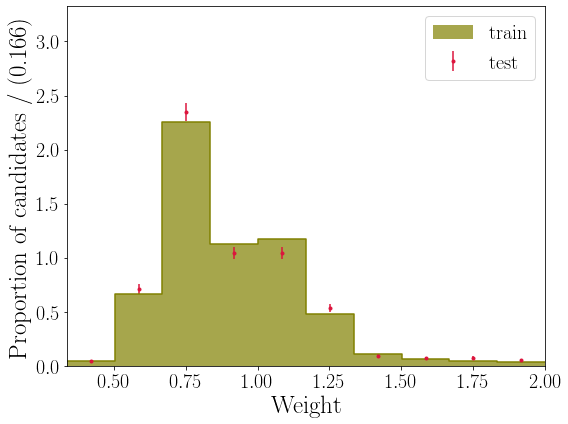

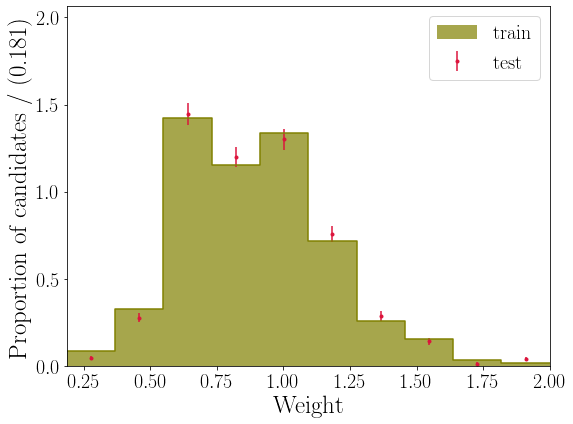

In [36]:
for num in reweighter.keys():
    plot_hist_var(
        [train_MC_weights[num],test_MC_weights[num]],
        branch='Weight', bar_mode=[True, False],
        alpha=[0.7, 0.4],
        data_names=['train', 'test'],
        n_bins=10, high=2,
        colors=['olive', 'crimson'], 
        folder_name=f'{MC_name}/{weight_MC_name}',
        fig_name=f'overtraining_{num}'
    )

In [37]:
weight_ks_2samp = {}
weight_ks_value = {}
weight_p_value = {}
for num in reweighter.keys():
    weight_ks_2samp[num] = ks_2samp(train_MC_weights[num], test_MC_weights[num])

    weight_ks_value[num] = weight_ks_2samp[num].statistic
    weight_p_value[num] = weight_ks_2samp[num].pvalue
    
    print(f"Reweighting {num}")
    print("KS score:", weight_ks_value[num])
    print("p-value:", weight_p_value[num])

Reweighting 1
KS score: 0.03896172115596293
p-value: 0.08492753431435018
Reweighting 2
KS score: 0.03159357255044098
p-value: 0.24942745112926368


#### For `max_depth = 2` and `learning_rate = 0.08`

With `n_estimators = 35` 

```
Reweighting 1
KS score: 0.04377431906614786
p-value: 0.03889657467847918
Reweighting 2
KS score: 0.046645101566962534
p-value: 0.02157499239513716
```



#### For `max_depth = 2` and `learning_rate = 0.1`

With `n_estimators = 20` (Best $\chi^2$)
```
Reweighting 1
KS score: 0.03939688715953307
p-value: 0.08223954424471516
Reweighting 2
KS score: 0.024321089032782944
p-value: 0.5638301497123446
```

With `n_estimators = 40` (Best $\chi^2$)
```
Reweighting 1
KS score: 0.045233463035019454
p-value: 0.02977816352950209
Reweighting 2
KS score: 0.05102845281577094
p-value: 0.008889137977158956
```

With `n_estimators = 45` (Best $\chi^2$)
```
Reweighting 1
KS score: 0.045233463035019454
p-value: 0.02977816352950209
Reweighting 2
KS score: 0.05102845281577094
p-value: 0.008889137977158956
```


With `n_estimators = 40` (Best $\chi^2$)
```
Reweighting 1
KS score: 0.04085603112840467
p-value: 0.06464056991337011
Reweighting 2
KS score: 0.040308630887039364
p-value: 0.06762029803360581
```



#### For `max_depth = 2` and `learning_rate = 0.01`

With `n_estimators = 300`  (Best $\chi^2$)
```
Reweighting 1
KS score: 0.04912451361867704
p-value: 0.01399271212323702
Reweighting 2
KS score: 0.03592195315744804
p-value: 0.1353170229371491
```



With `n_estimators = 350`  (Best $\chi^2$)
```
Reweighting 1
KS score: 0.04815175097276265
p-value: 0.016999690288906646
Reweighting 2
KS score: 0.04225961186622225
p-value: 0.04840952168424406
```

With `n_estimators = 500` (Donal's choice)
```
Reweighting 1
KS score: 0.060797665369649805
p-value: 0.0009983581316908117
Reweighting 2
KS score: 0.03938101796014496
p-value: 0.07873429160457257
```

With `n_estimators = 150` (p-value > 0.1 for lowest $\chi^2$)
```
Reweighting 1
KS score: 0.03599221789883268
p-value: 0.13938145891234918
Reweighting 2
KS score: 0.027688438008179342
p-value: 0.397946608200094
```


#### For `max_depth = 3` and `learning_rate = 0.01`

With `n_estimators = 150` (Best $\chi^2$)
```
Reweighting 1
KS score: 0.060797665369649805
p-value: 0.0009983581316908117
Reweighting 2
KS score: 0.03938101796014496
p-value: 0.07873429160457257
```

With `n_estimators = 500` (Donal's choice)
```
KS score: 0.06760700389105058
p-value: 0.0001650754304829554
Reweighting 2
KS score: 0.058861364636467926
p-value: 0.0014983101846401947
```

With `n_estimators = 100` (p-value > 0.01 for lowest $\chi^2$)
```
Reweighting 1
KS score: 0.048638132295719845
p-value: 0.015430611756470612
Reweighting 2
KS score: 0.03941642121990604
p-value: 0.07852839946301926
```


For default hyperparameters
```
Reweighting 1
KS score: 0.07003891050583658
p-value: 8.286816973553847e-05
Reweighting 2
KS score: 0.062321617468015886
p-value: 0.0006368989083538334
```

## Apply reweighting

In [38]:
two_dfs[1]['MC']['weight'] = reweighter[2].predict_weights(reweight_two_dfs[1]['MC'])
two_dfs[2]['MC']['weight'] = reweighter[1].predict_weights(reweight_two_dfs[2]['MC'])

In [39]:
save_df = {}
for type_df in df.keys():
    save_df[type_df] = pd.concat([two_dfs[1][type_df],two_dfs[2][type_df]])

## Save

In [40]:
save_root(save_df['MC'], weight_MC_name, 'DecayTree', folder_name=MC_name)

Root file saved in /home/correiaa/bd2dsttaunu/output/root/BTODstDX_MC/BTODstDX_MC_weights.root


In [41]:
for num in reweighter.keys():
    dump_joblib(reweighter[num], f"{weight_MC_name}_{num}", folder_name=MC_name)

Joblib file saved in /home/correiaa/bd2dsttaunu/output/joblib/BTODstDX_MC/BTODstDX_MC_weights_1.joblib
Joblib file saved in /home/correiaa/bd2dsttaunu/output/joblib/BTODstDX_MC/BTODstDX_MC_weights_2.joblib
